In [1]:
from datasets import load_dataset, concatenate_datasets

In [17]:
import numpy as np

def get_stats(data):
    words_num = data.map(lambda x: {"text_words_num": len(x["text"].split()), "summary_words_num": len(x["summary"].split())})
    avg_words_num_text = np.mean(words_num["text_words_num"])
    avg_words_num_summary = np.mean(words_num["summary_words_num"])

    return avg_words_num_text, avg_words_num_summary

In [18]:
data1 = load_dataset("reciTAL/mlsum", 'ru')

full_data1 = concatenate_datasets([
    data1["train"],
    data1["validation"],
    data1["test"]
])
full_data1 = full_data1.remove_columns(['topic', 'url', 'title', 'date'])
print(len(full_data1))

get_stats(full_data1)

27063


(790.2411040904556, 12.775006466393231)

In [19]:
data2 = load_dataset("IlyaGusev/gazeta")

full_data2 = concatenate_datasets([
    data2["train"],
    data2["validation"],
    data2["test"]
])
full_data2 = full_data2.remove_columns(['title', 'date', 'url'])
print(len(full_data2))

get_stats(full_data2)

74126


(628.2115721878963, 42.660550953781396)

In [20]:
data3 = load_dataset("csebuetnlp/xlsum", "russian")

full_data3 = concatenate_datasets([
    data3["train"],
    data3["test"],
    data3["validation"]
])
full_data3 = full_data3.remove_columns(['id', 'url', 'title'])
print(len(full_data3))

get_stats(full_data3)

77803


(547.6641132090023, 25.173039600015425)

In [21]:
data4 = load_dataset("GEM/wiki_lingua", "ru")

full_data4 = concatenate_datasets([
    data4["train"],
    data4["validation"],
    data4["test"]
])
full_data4 = full_data4.remove_columns(['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'references'])
full_data4 = full_data4.rename_columns({"source": "text", "target": "summary"})
print(len(full_data4))

get_stats(full_data4)

50259


(321.91860164348674, 27.94172188065819)

In [ ]:
combined_data = concatenate_datasets([full_data1, full_data2, full_data3, full_data4])
combined_data.save_to_disk("../data/combined_data")

Saving the dataset (0/4 shards):   0%|          | 0/229251 [00:00<?, ? examples/s]

In [1]:
%load_ext autoreload
%autoreload 2

import data_tools

# TEST

In [2]:
from datasets import load_dataset

raw = load_dataset("RussianNLP/Mixed-Summarization-Dataset")
raw = raw['test']

In [24]:
import pandas as pd

test = pd.read_csv("../data/test_hand_instruct.csv", sep="|")

<Axes: >

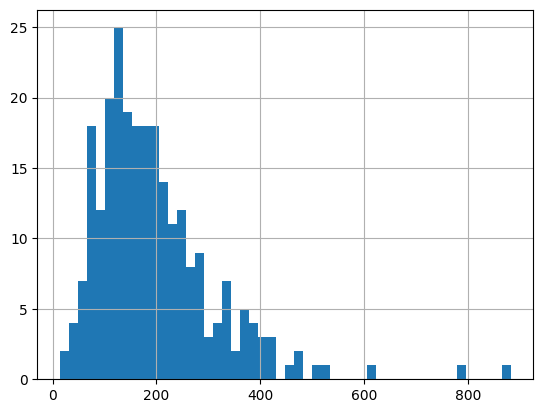

In [39]:
test[test["source_words"]<1000]["source_words"].hist(bins=50)

<Axes: >

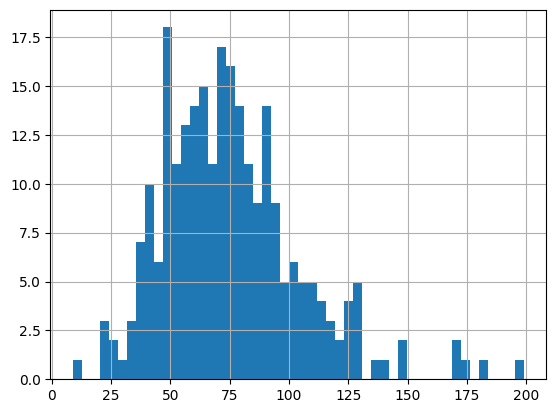

In [40]:
test[test["target_words"]<200]["target_words"].hist(bins=50)

In [6]:
from datasets import Dataset

filtered_test = Dataset.from_pandas(test).filter(is_short_enough)

def remove_instruction(example):
    text = example['text']
    return {'text': text.split('\n', 1)[-1].strip()[1:-1]}
filtered_test = filtered_test.map(remove_instruction)

Filter:   0%|          | 0/258 [00:00<?, ? examples/s]

Map:   0%|          | 0/247 [00:00<?, ? examples/s]

In [ ]:
filtered_test.save_to_disk('../data/filtered_test')

Saving the dataset (0/1 shards):   0%|          | 0/247 [00:00<?, ? examples/s]

# TRAIN

In [ ]:
from datasets import load_from_disk

train = load_from_disk('../data/combined_data')
train_filtered = train.filter(data_tools.is_short_enough, num_proc=16)

In [ ]:
# data_stats = train_filtered.map(count, num_proc=16)

In [ ]:
# import evaluate
# bertscore = evaluate.load("bertscore")

# def compute_bertscore_batch(batch):
#     results = bertscore.compute(predictions=batch["summary"],
#                                 references=batch["text"],
#                                 lang="ru", device="cuda:0", batch_size=126)
#     return {"bertscore_f1": results["f1"], "bertscore_precision": results["precision"], "bertscore_recall": results["recall"]}
# scored_dataset = train_filtered.map(compute_bertscore_batch, batched=True, batch_size=256)

In [ ]:
# import pandas as pd

# df1 = pd.read_csv("../data/bertscore40000.csv")
# df2 = pd.read_csv("../data/bertscore80000.csv")
# df3 = pd.read_csv("../data/bertscore120000.csv")
# df4 = pd.read_csv("../data/bertscore173138.csv")

# df_ = pd.concat([df1, df2, df3, df4], ignore_index=True)
# df_.drop(columns=["Unnamed: 0", 'text', 'summary'], inplace=True)

# df = pd.concat([pd.DataFrame(data_stats), df_], axis=1)
# df.to_csv("../data/data_stats.csv")

In [103]:
import pandas as pd

df = pd.read_csv("../data/data_stats.csv")
df.shape, df.columns

((173138, 13),
 Index(['index', 'text', 'summary', 'input_tokens', 'target_tokens',
        'input_words', 'target_words', 'bertscore_f1', 'bertscore_precision',
        'bertscore_recall', 'compression_ratio_words',
        'compression_ratio_tokens', 'lang'],
       dtype='object'))

In [104]:
# from datasets import Dataset
# from langdetect import detect

# dataset = Dataset.from_pandas(df)
# dataset = dataset.map(lambda x: {"lang": detect(x["text"])}, num_proc=20)

In [105]:
# df_ = pd.concat([df1, df2, df3, df4], ignore_index=True)
# for i in range(len(df)):
#     assert df.iloc[i]['summary'] == df_.iloc[i]['summary'], f"{i}"

In [106]:
# dupes = df[df.duplicated('text', keep=False)].sort_values('text')
# # SEARCH FOR DUPLICATES
# for text, group in dupes.groupby('text'):
#     print(f"\n--- TEXT ---\n{text[:300]}")
#     print("--- SUMMARIES ---")
#     for _, row in group.iterrows():
#         print(f"- {row['bertscore_f1']:.4f} {row['summary']}")

df = (
    df.assign(summary_length=lambda d: d['target_words'])
      .sort_values(by=['text', 'summary_length'], ascending=[True, False])
      .drop_duplicates(subset='text', keep='first')
      .drop(columns=['summary_length'])
)

df = (
    df.assign(text_length=lambda d: d['input_words'])
      .sort_values(by=['summary', 'text_length'], ascending=[True, False])
      .drop_duplicates(subset='summary', keep='first')
      .drop(columns=['text_length'])
)

df.sort_index(inplace=True)

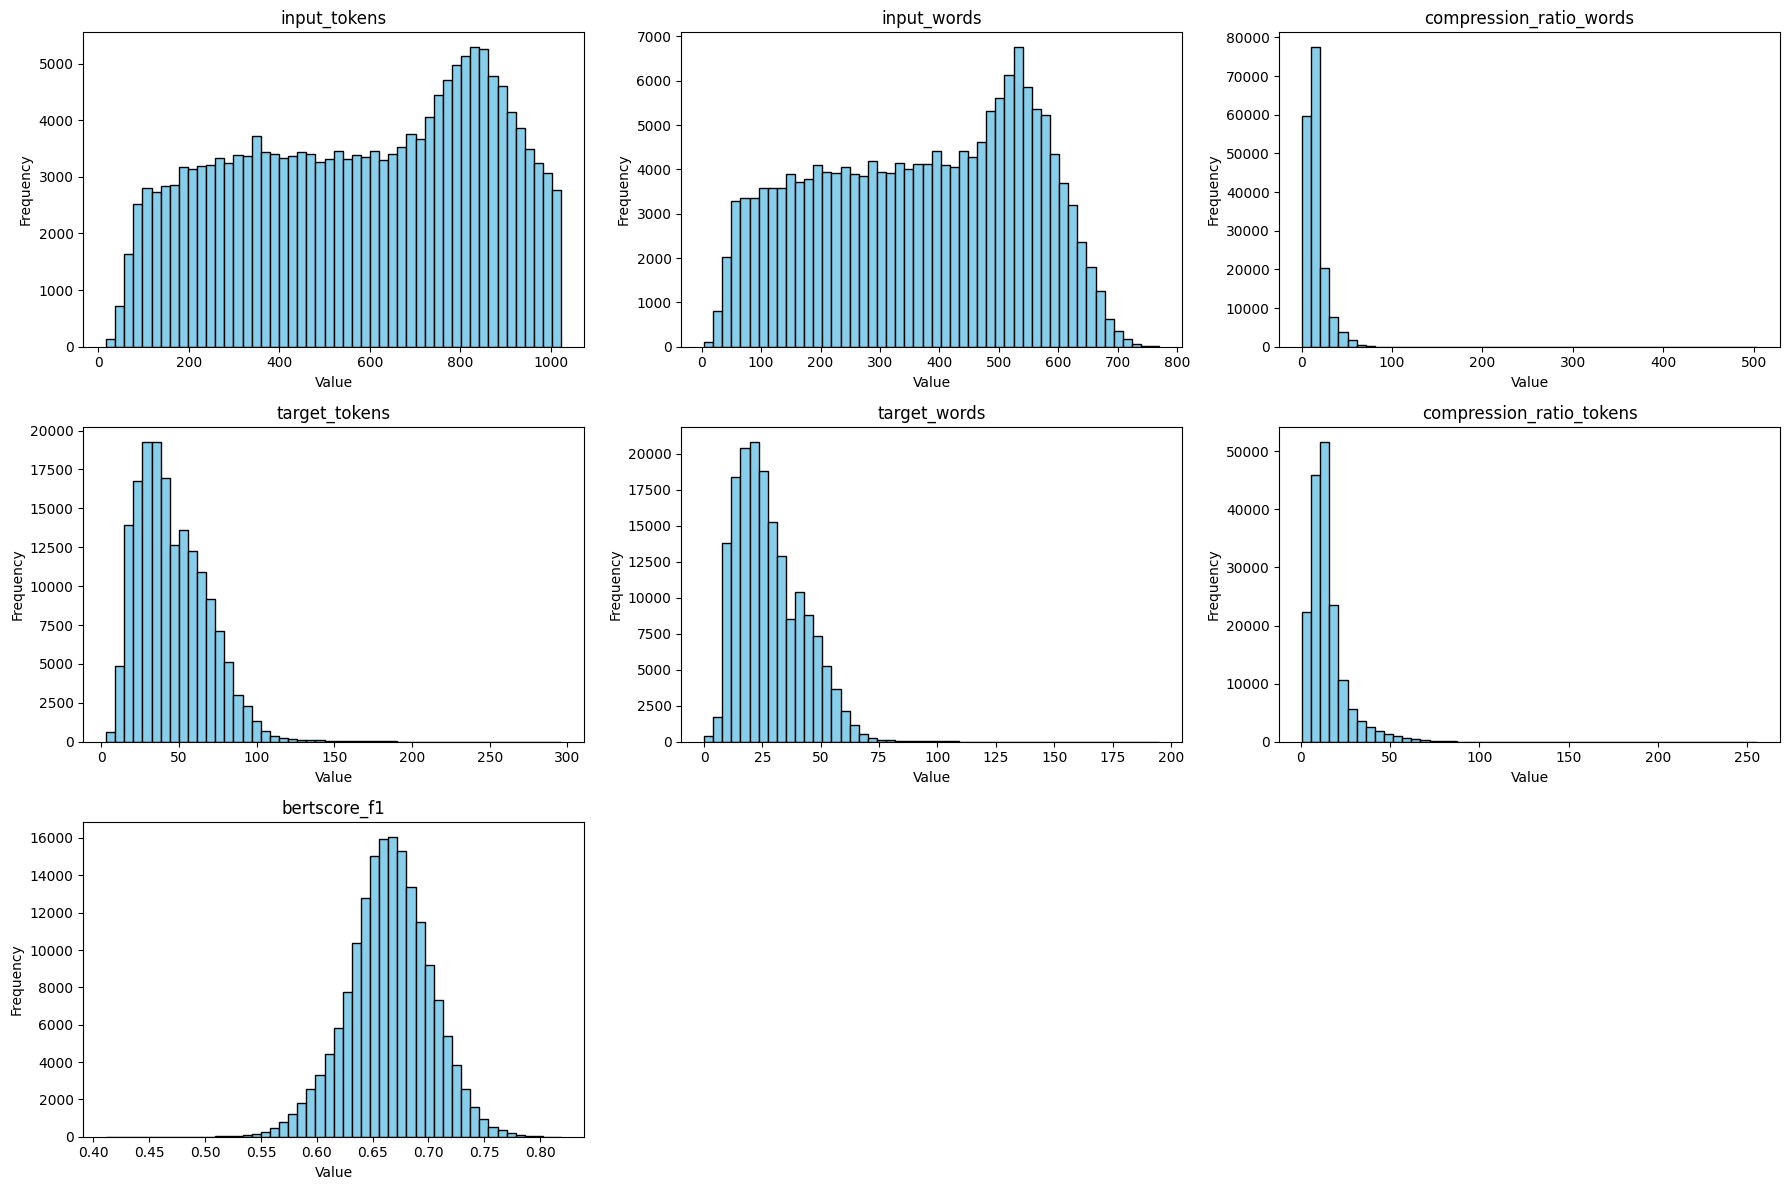

In [169]:
data_tools.plot_histograms(df, add_fields=["bertscore_f1"])

In [42]:
# for i in df[(df["bertscore_f1"] > 0.7) & (df["compression_ratio_words"] > 0.08) & (df["compression_ratio_words"] < 0.2) & (df["target_words"] >= 10) & (df["lang"] == "ru")].sample(1).iterrows():
#     print(i[1]["source_words"], i[1]["text"])
#     print(i[1]["target_words"], i[1]["summary"])
#     print(i[1]["compression_ratio_words"])
#     print(i[1]["bertscore_f1"])

In [43]:
df.columns

Index(['index', 'text', 'summary', 'input_tokens', 'target_tokens',
       'input_words', 'target_words', 'bertscore_f1', 'bertscore_precision',
       'bertscore_recall', 'compression_ratio_words',
       'compression_ratio_tokens', 'lang'],
      dtype='object')

In [175]:
df1 = df[(df["bertscore_f1"] > 0.7) & (df["compression_ratio_tokens"] > 3) & (df["compression_ratio_tokens"] < 10) & (df["target_words"] >= 10) & (df['target_tokens'] < 230) & (df["lang"] == "ru")]
df1.shape

(11143, 13)

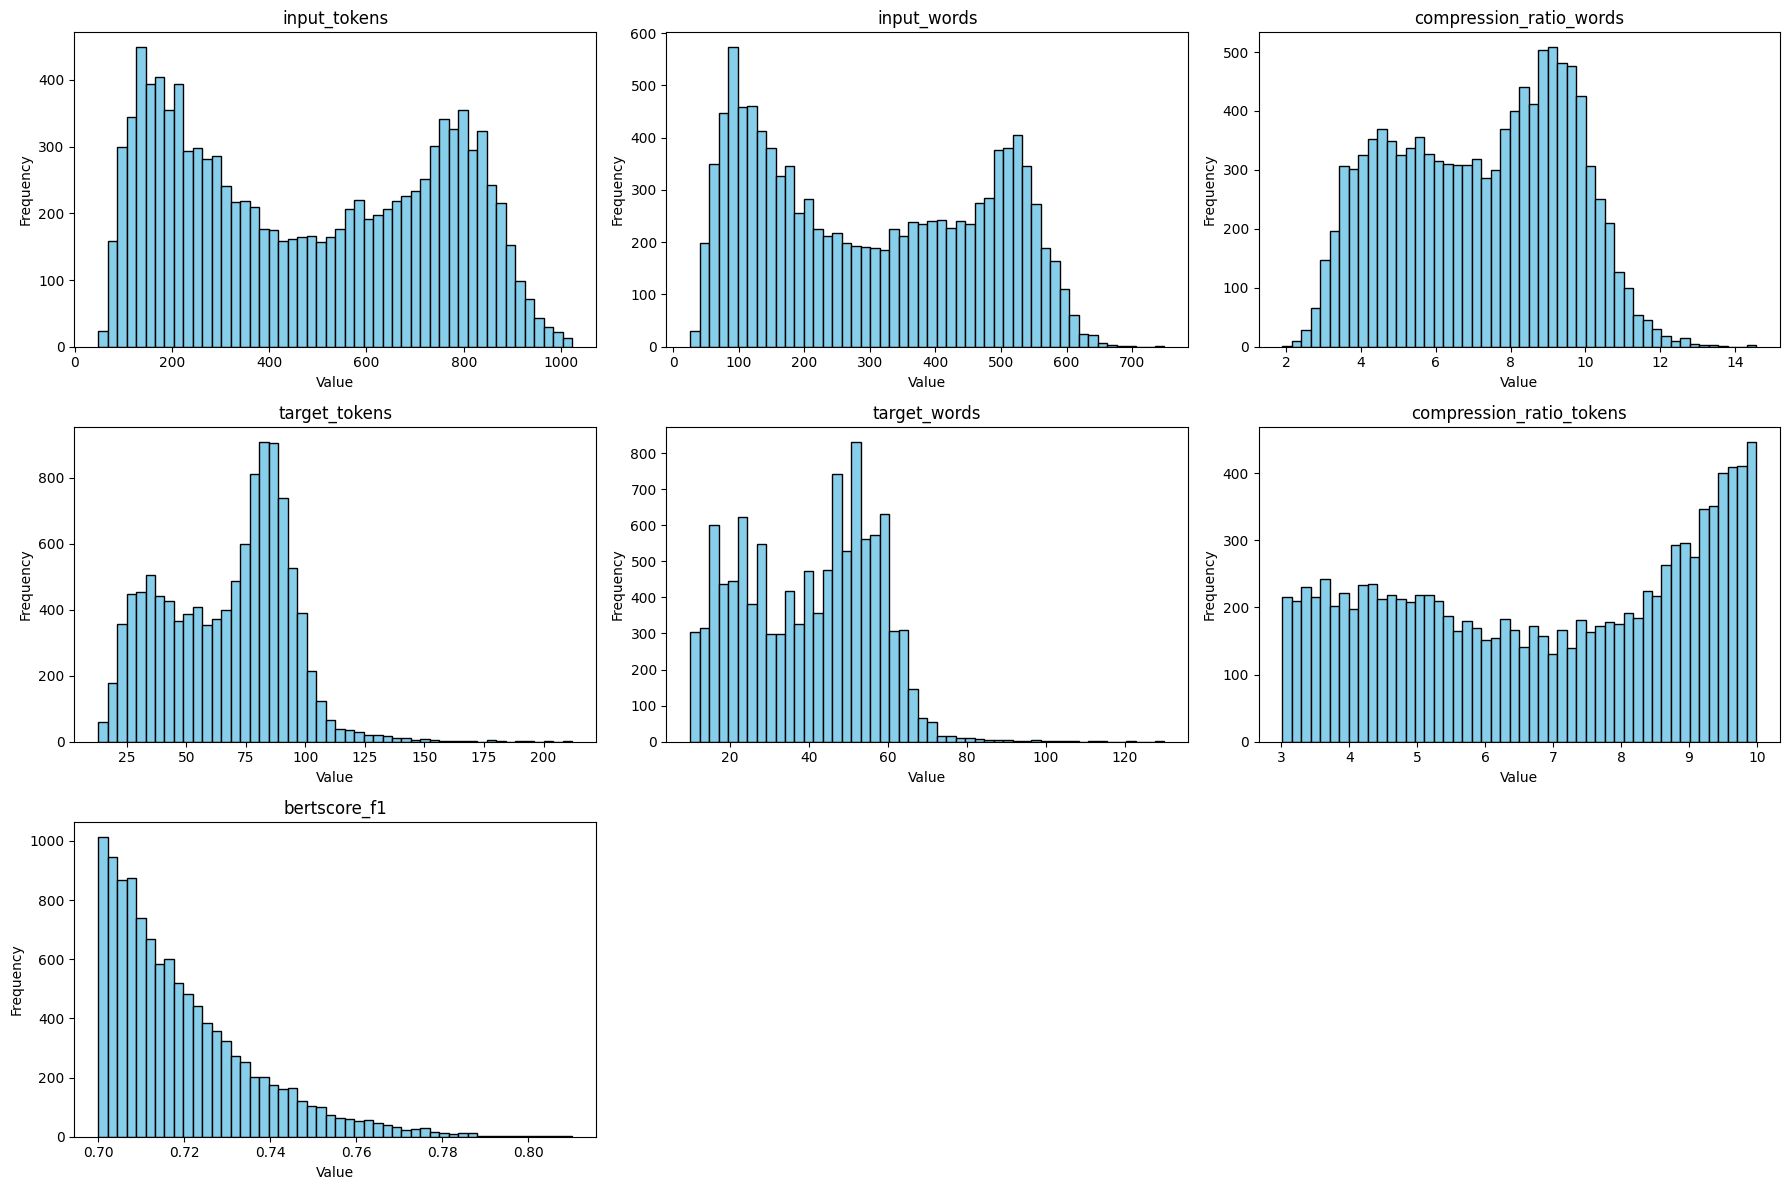

In [176]:
data_tools.plot_histograms(df1, add_fields=["bertscore_f1"])

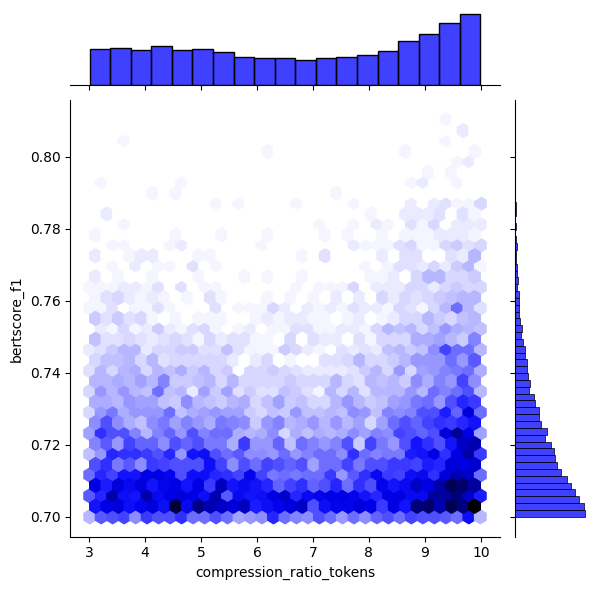

In [177]:
import seaborn as sns

sns.jointplot(
    data=df1,
    x='compression_ratio_tokens',
    y='bertscore_f1',
    kind='hex', # варианты: 'scatter', 'hex', 'kde'
    bins=50,
    color='blue'
)

In [87]:
from datasets import Dataset 

Dataset.from_pandas(df1).save_to_disk("../data/filtered_dedup_data")

Saving the dataset (0/1 shards):   0%|          | 0/45695 [00:00<?, ? examples/s]

In [ ]:
# from datasets import load_from_disk

# load_from_disk('../data/filtered_dedup_data')

Dataset({
    features: ['index', 'Unnamed: 0', 'text', 'summary', 'input_tokens', 'target_tokens', 'source_words', 'target_words', 'bertscore_f1', 'bertscore_precision', 'bertscore_recall', 'lang', 'compression_ratio_words', '__index_level_0__'],
    num_rows: 45695
})

# Synthetic Summaries Filtering

In [46]:
from datasets import load_from_disk, concatenate_datasets

nplus1_raw = load_from_disk("../../nplus1_gemini")
fontanka_raw = load_from_disk("../../fontanka_gemini")
synth_raw = concatenate_datasets([nplus1_raw, fontanka_raw])

In [ ]:
# def process_entry(x):
#     total_removed = 0
#     new_summaries = []
#     for i in x["summaries"]:
#         new_text, removed = data_tools.remove_link_sentences(i)
#         new_summaries.append(new_text)
#         total_removed += removed
#     x["summaries"] = new_summaries
#     x["removed_count"] = total_removed
#     return x

# synth_raw = synth_raw.map(process_entry, num_proc=4)

# total_removed = sum(synth_raw["removed_count"])
# print(f"Total removed: {total_removed}")

In [48]:
# from sentence_transformers import SentenceTransformer, util
# import torch

# MODEL_NAME = "intfloat/multilingual-e5-large"

# def select_best_summary(examples):
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model = SentenceTransformer(MODEL_NAME, device=device)

#     source_texts = examples['text']
#     candidate_summaries_list = examples['summaries']

#     all_texts_to_encode = []
#     candidate_indices_in_flat_list_per_example = []
#     current_flat_index = 0

#     for text, summaries in zip(source_texts, candidate_summaries_list):
#         all_texts_to_encode.append("query: " + text)
#         current_flat_index += 1

#         current_example_candidate_indices = []
#         for summary in summaries:
#             all_texts_to_encode.append("passage: " + summary.strip())
#             current_example_candidate_indices.append(current_flat_index)
#             current_flat_index += 1

#         candidate_indices_in_flat_list_per_example.append(current_example_candidate_indices)

#     embeddings = model.encode(
#         all_texts_to_encode,
#         convert_to_tensor=True,
#         device=device,
#     )

#     selected_summaries = []
#     flat_emb_current_index = 0

#     for i in range(len(source_texts)):
#         source_embedding = embeddings[flat_emb_current_index].unsqueeze(0)
#         flat_emb_current_index += 1

#         example_candidate_indices = candidate_indices_in_flat_list_per_example[i]
#         candidate_embeddings = embeddings[example_candidate_indices]
#         cosine_scores = util.pytorch_cos_sim(source_embedding, candidate_embeddings)[0]
#         best_index = torch.argmax(cosine_scores).item()
#         best_flat_index = example_candidate_indices[best_index]
#         best_summary = all_texts_to_encode[best_flat_index].replace("passage: ", "")
#         flat_emb_current_index += len(example_candidate_indices)

#         selected_summaries.append(best_summary)

#     return {'text': source_texts, 'summary': selected_summaries}

# processed_dataset = synth_raw.map(
#     select_best_summary,
#     batched=True,
#     batch_size=256, 
#     remove_columns=synth_raw.column_names,
# )

# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [49]:
# is_longest = []
# for selected_summary, candidate_summaries in zip(processed_dataset['summary'], synth_raw['summaries']):
#     candidate_summaries = [s.strip() for s in candidate_summaries]
#     lengths = [len(s) for s in candidate_summaries]
#     max_length = max(lengths)
#     max_length_indices = [i for i, l in enumerate(lengths) if l == max_length]
#     selected_index = candidate_summaries.index(selected_summary)
#     is_longest.append(1 if selected_index in max_length_indices else 0)
# percentage = sum(is_longest) / len(is_longest)
# print(f"Победитель является самым длинным саммари в {percentage:.2%} случаев.")
# processed_dataset.save_to_disk('../data/synthetic_data')

In [50]:
# from datasets import load_from_disk, concatenate_datasets

# nplus1_raw = load_from_disk("../../nplus1_gemini")
# fontanka_raw = load_from_disk("../../fontanka_gemini")

# def choose_sortest(example):
#     lens = [len(i) for i in example['summaries']]
#     shortest = example['summaries'][lens.index(min(lens))]
#     return {'text': example['text'], 'summary': shortest}


# nplus1_raw = nplus1_raw.map(
#     choose_sortest,
#     remove_columns=nplus1_raw.column_names,
# )

# fontanka_raw = fontanka_raw.map(
#     choose_sortest,
#     remove_columns=fontanka_raw.column_names,
# )

# synth_data = concatenate_datasets([nplus1_raw, fontanka_raw])

In [51]:
from datasets import load_from_disk

processed_dataset = load_from_disk("../data/synthetic_data")
processed_dataset

Dataset({
    features: ['text', 'summary', 'score'],
    num_rows: 24193
})

In [52]:
# import os
# import gc
# import torch
# from torch.utils.data import DataLoader
# from datasets import Dataset
# from transformers import (
#     AutoTokenizer,
#     AutoModelForSeq2SeqLM,
#     DataCollatorForSeq2Seq,
#     GenerationConfig
# )
# from tqdm.auto import tqdm

# SCORING_BATCH_SIZE = 180
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# SCORING_MODEL_NAME = "google/seahorse-large-q6"
# SEAHORSE_FORMAT_GOOGLE = "premise: {} hypothesis: {}"
# SEAHORSE_ZERO_TOKEN = '▁0'
# SEAHORSE_ONE_TOKEN = '▁1'
# MAX_INPUT_LENGTH = 1024
# MAX_TARGET_LENGTH = 300

# score_tokenizer = AutoTokenizer.from_pretrained(SCORING_MODEL_NAME)
# score_model = AutoModelForSeq2SeqLM.from_pretrained(SCORING_MODEL_NAME)
# score_model.to(DEVICE)
# score_model.eval()
# seahorse_zero_token_id = score_tokenizer(SEAHORSE_ZERO_TOKEN, add_special_tokens=False).input_ids[0]
# seahorse_one_token_id = score_tokenizer(SEAHORSE_ONE_TOKEN, add_special_tokens=False).input_ids[0]

# def preprocess_for_scoring(texts, summaries, tokenizer):
#     inputs = [SEAHORSE_FORMAT_GOOGLE.format(text, summary) for text, summary in zip(texts, summaries)]
#     tokenized = tokenizer(
#         inputs,
#         max_length=MAX_INPUT_LENGTH + MAX_TARGET_LENGTH + 10,
#         truncation=True,
#         padding=False, # Defer padding to DataCollator
#     )
#     return tokenized

# scoring_dataset_tokenized = processed_dataset.map(
#     lambda examples: preprocess_for_scoring(examples["text"], examples["summary"], score_tokenizer),
#     batched=True,
#     remove_columns=processed_dataset.column_names,
#     num_proc=os.cpu_count()//2 if os.cpu_count() else 1
# )
# scoring_dataset_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# scoring_dataloader = DataLoader(
#     scoring_dataset_tokenized,
#     batch_size=SCORING_BATCH_SIZE,
#     collate_fn=DataCollatorForSeq2Seq(score_tokenizer, model=score_model, padding=True),
# )

# all_scores_flat = []
# for batch in tqdm(scoring_dataloader, desc="Scoring Summaries"):
#     input_ids = batch['input_ids'].to(DEVICE)
#     attention_mask = batch['attention_mask'].to(DEVICE)

#     with torch.no_grad():
#         outputs = score_model.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=1,
#             return_dict_in_generate=True,
#             output_scores=True,
#         )
#         logits = outputs["scores"][0]

#         logit_for_0 = logits[:, seahorse_zero_token_id]
#         logit_for_1 = logits[:, seahorse_one_token_id]

#         scores = torch.sigmoid(logit_for_1 - logit_for_0).cpu().numpy()
#         all_scores_flat.extend(scores)

#     del input_ids, attention_mask, outputs, logits, logit_for_0, logit_for_1, scores
#     gc.collect()
#     torch.cuda.empty_cache()

# processed_dataset = processed_dataset.add_column("score", all_scores_flat)
# processed_dataset.save_to_disk('../data/synthetic_data')

In [53]:
processed_dataset = processed_dataset.map(data_tools.count, num_proc=16)

In [ ]:
def process_entry(x):
    new_text, removed = data_tools.remove_link_sentences(x['text'])
    x["text"] = new_text
    x["removed_count"] = removed
    return x

processed_dataset = processed_dataset.map(process_entry, num_proc=4)

total_removed = sum(processed_dataset["removed_count"])
print(f"Total removed: {total_removed}")

bad_pattern = re.compile(r'благотворительный фонд', re.IGNORECASE)
def filt(x):
    return not bad_pattern.search(x['text'])

processed_dataset = processed_dataset.filter(filt, num_proc=4)

Map (num_proc=4):   0%|          | 0/24193 [00:00<?, ? examples/s]

Total removed: 423


Filter (num_proc=4):   0%|          | 0/24193 [00:00<?, ? examples/s]

In [ ]:
# import re
# from nltk.tokenize import sent_tokenize

# link_pattern = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)

# linked_sentences = []

# for i, v in enumerate(df_synth['text'].dropna()):
#     sentences = sent_tokenize(v, language='russian')
#     for sent in sentences:
#         if link_pattern.search(sent):
#             linked_sentences.append((i, sent.strip()))

# print(len(linked_sentences))
# for i in linked_sentences[:1000]:
#     print(i)

In [55]:
df_synth = processed_dataset.to_pandas()

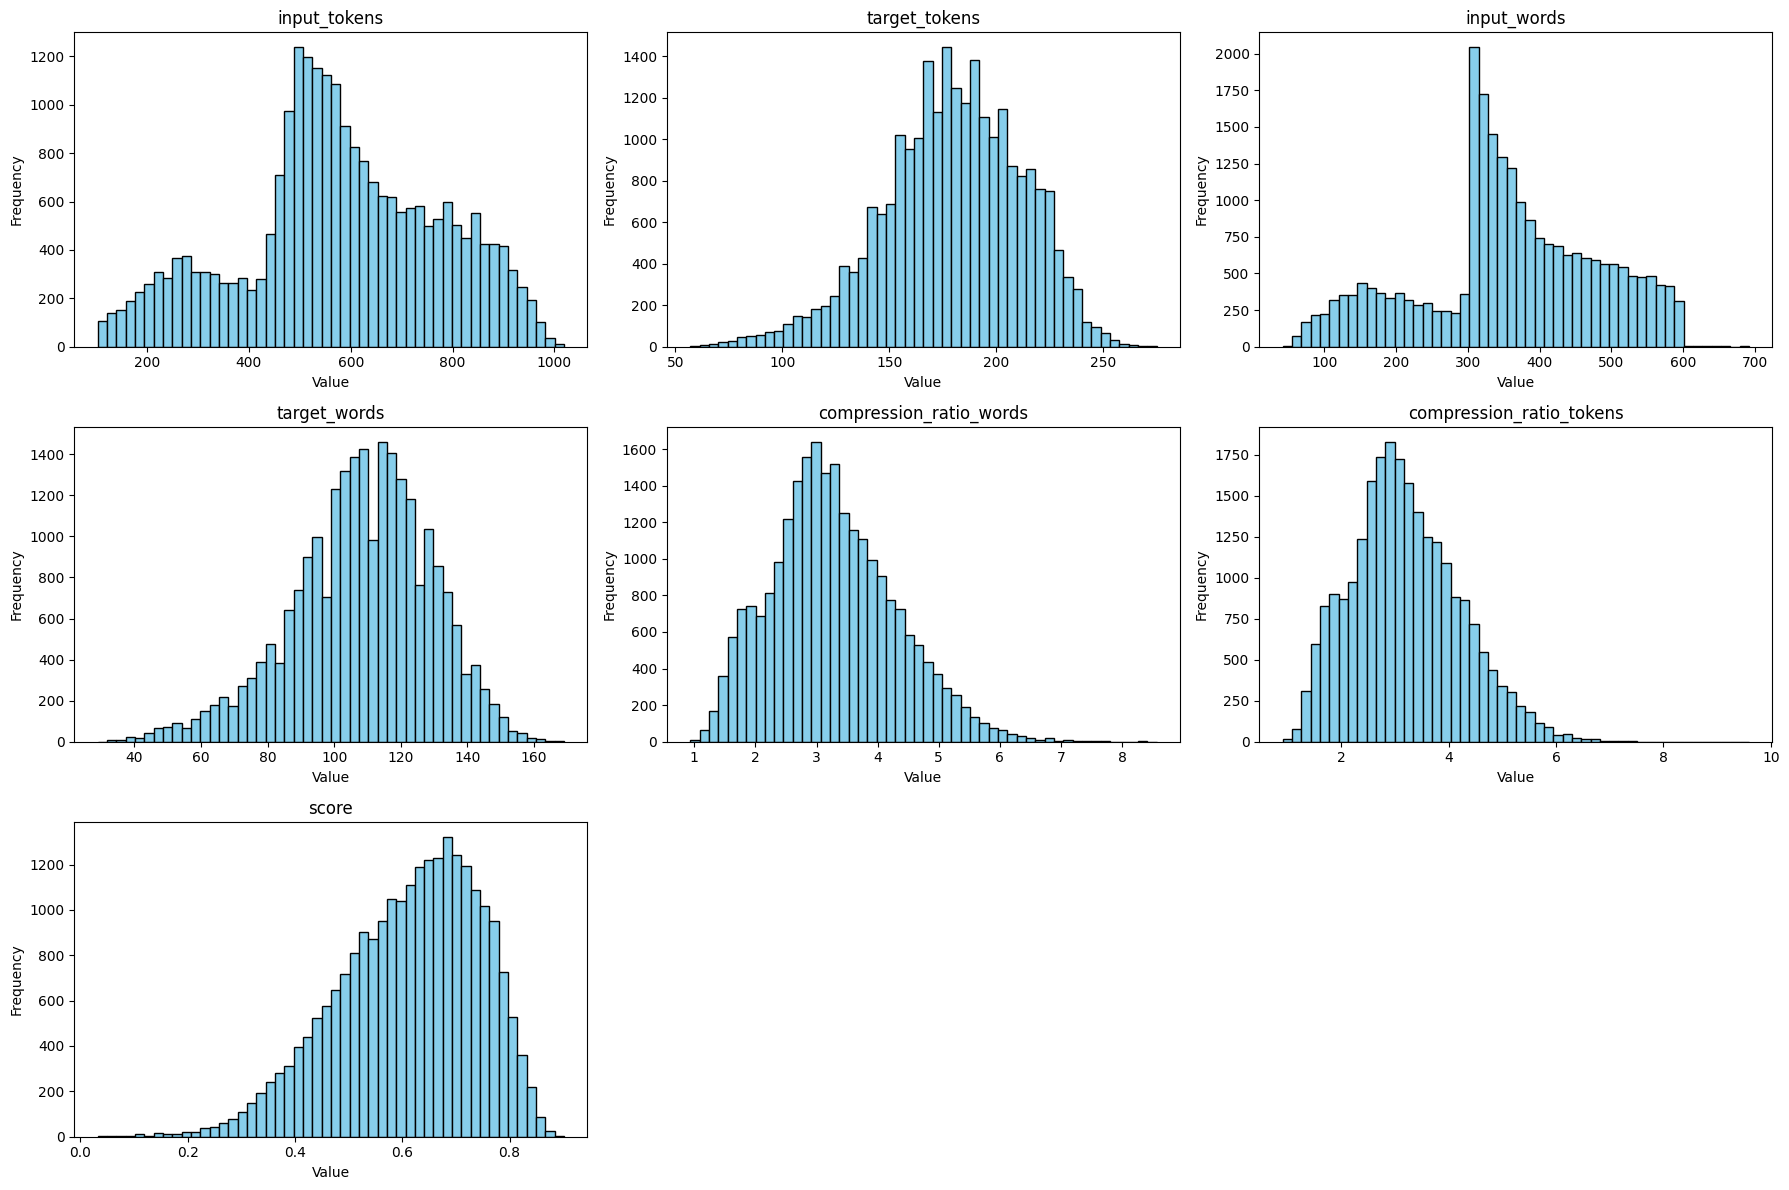

In [56]:
data_tools.plot_histograms(df_synth, add_fields=["score"])

In [57]:
nplus1 = df_synth[:len(nplus1_raw)].copy()
fontanka = df_synth[len(nplus1_raw):].copy()

len(nplus1), len(fontanka), len(nplus1) + len(fontanka)

(6855, 17196, 24051)

In [61]:
nplus1.sort_values(['score'], inplace=True)
fontanka.sort_values(['score'], inplace=True)

In [66]:
TEST_SIZE = 300
nplus1_train = nplus1[:-TEST_SIZE]
nplus1_test = nplus1[-TEST_SIZE:]
fontanka_train = fontanka[:-TEST_SIZE]
fontanka_test = fontanka[-TEST_SIZE:]

In [67]:
full_test = pd.concat([nplus1_test, fontanka_test], ignore_index=True)
full_train = pd.concat([nplus1_train, fontanka_train], ignore_index=True)

In [143]:
from datasets import Dataset

Dataset.from_pandas(full_test[['text', 'summary']]).save_to_disk("../data/synth_test")

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

In [131]:
full_train["rev_comp"] = 1 / full_train["compression_ratio_tokens"]

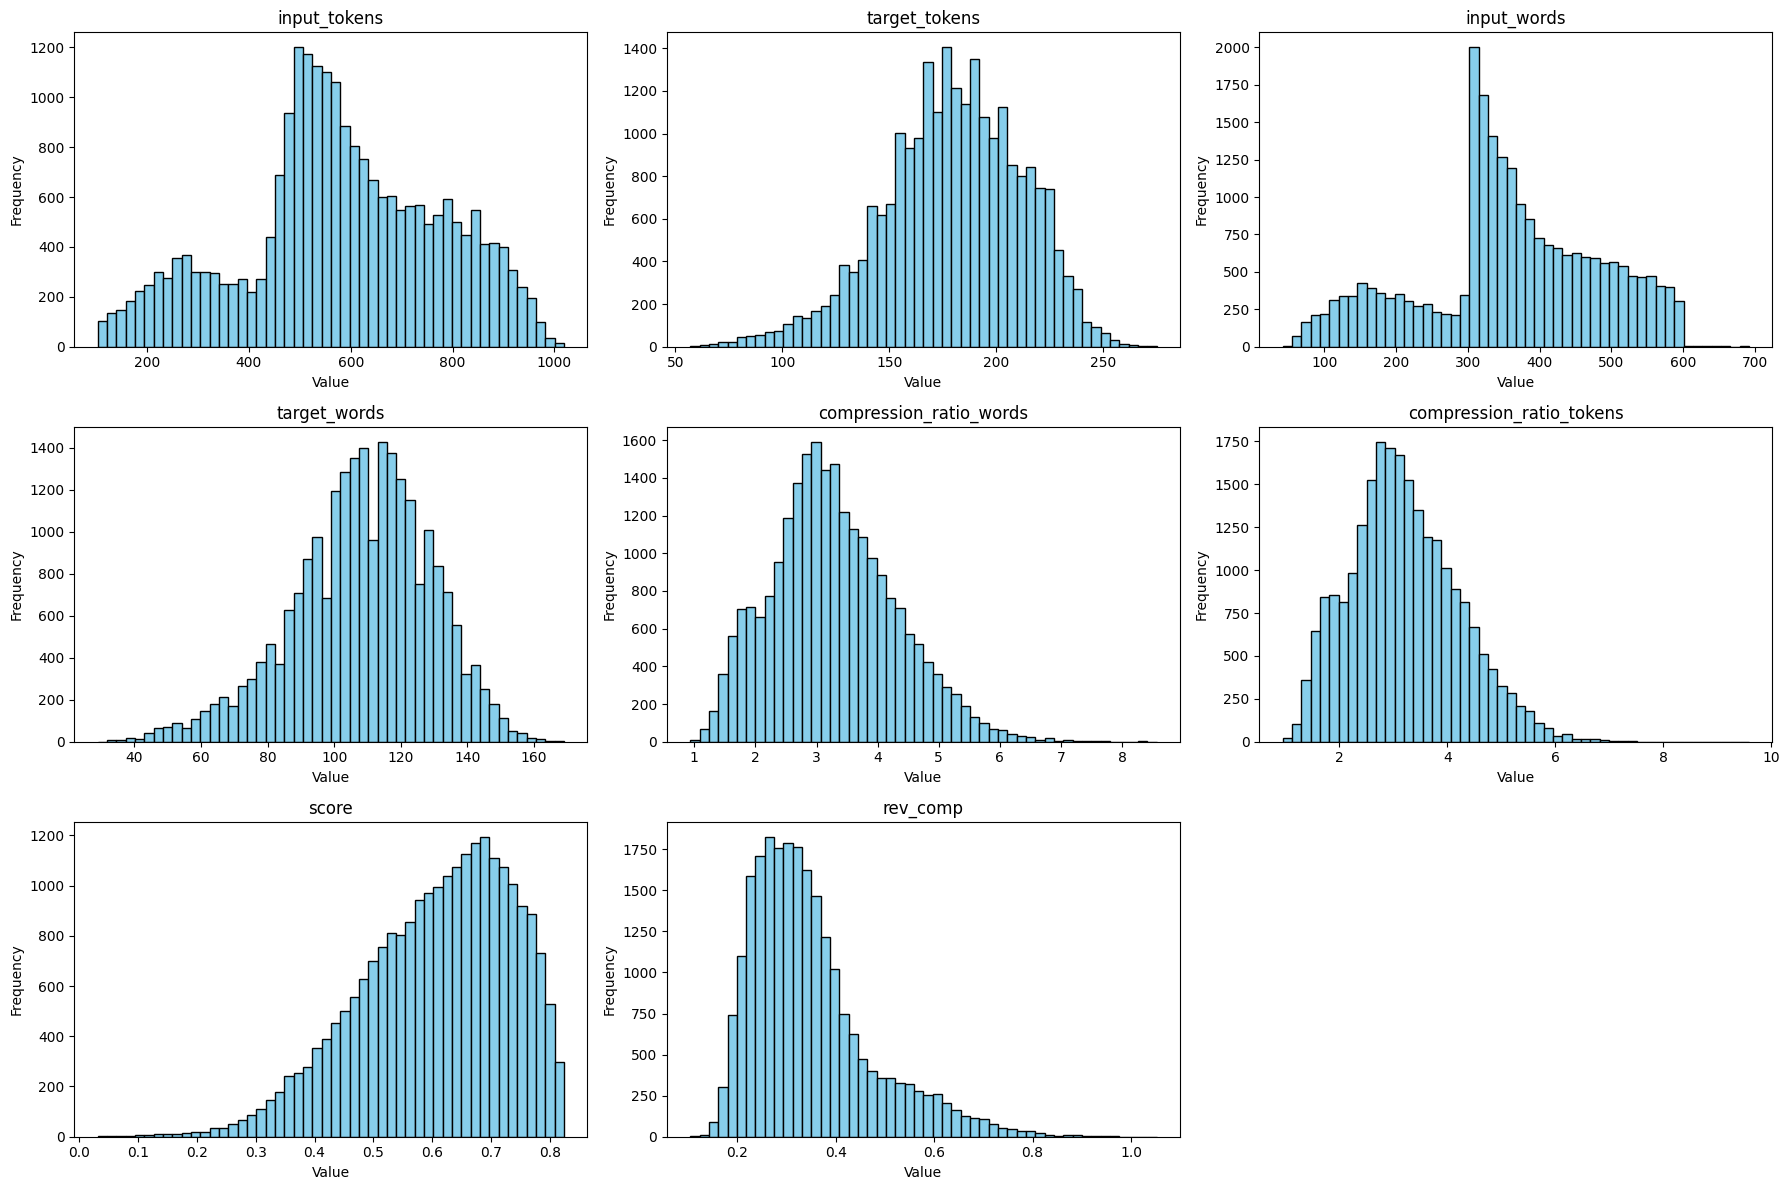

In [132]:
data_tools.plot_histograms(full_train, add_fields=["score", "rev_comp"])

In [ ]:
full_train.shape

(23451, 11)

In [209]:
fultered_train = full_train.copy()
fultered_train = fultered_train[(fultered_train['compression_ratio_tokens'] > 2.2) & (fultered_train['target_tokens'] < 230)]
fultered_train.shape

(18603, 11)

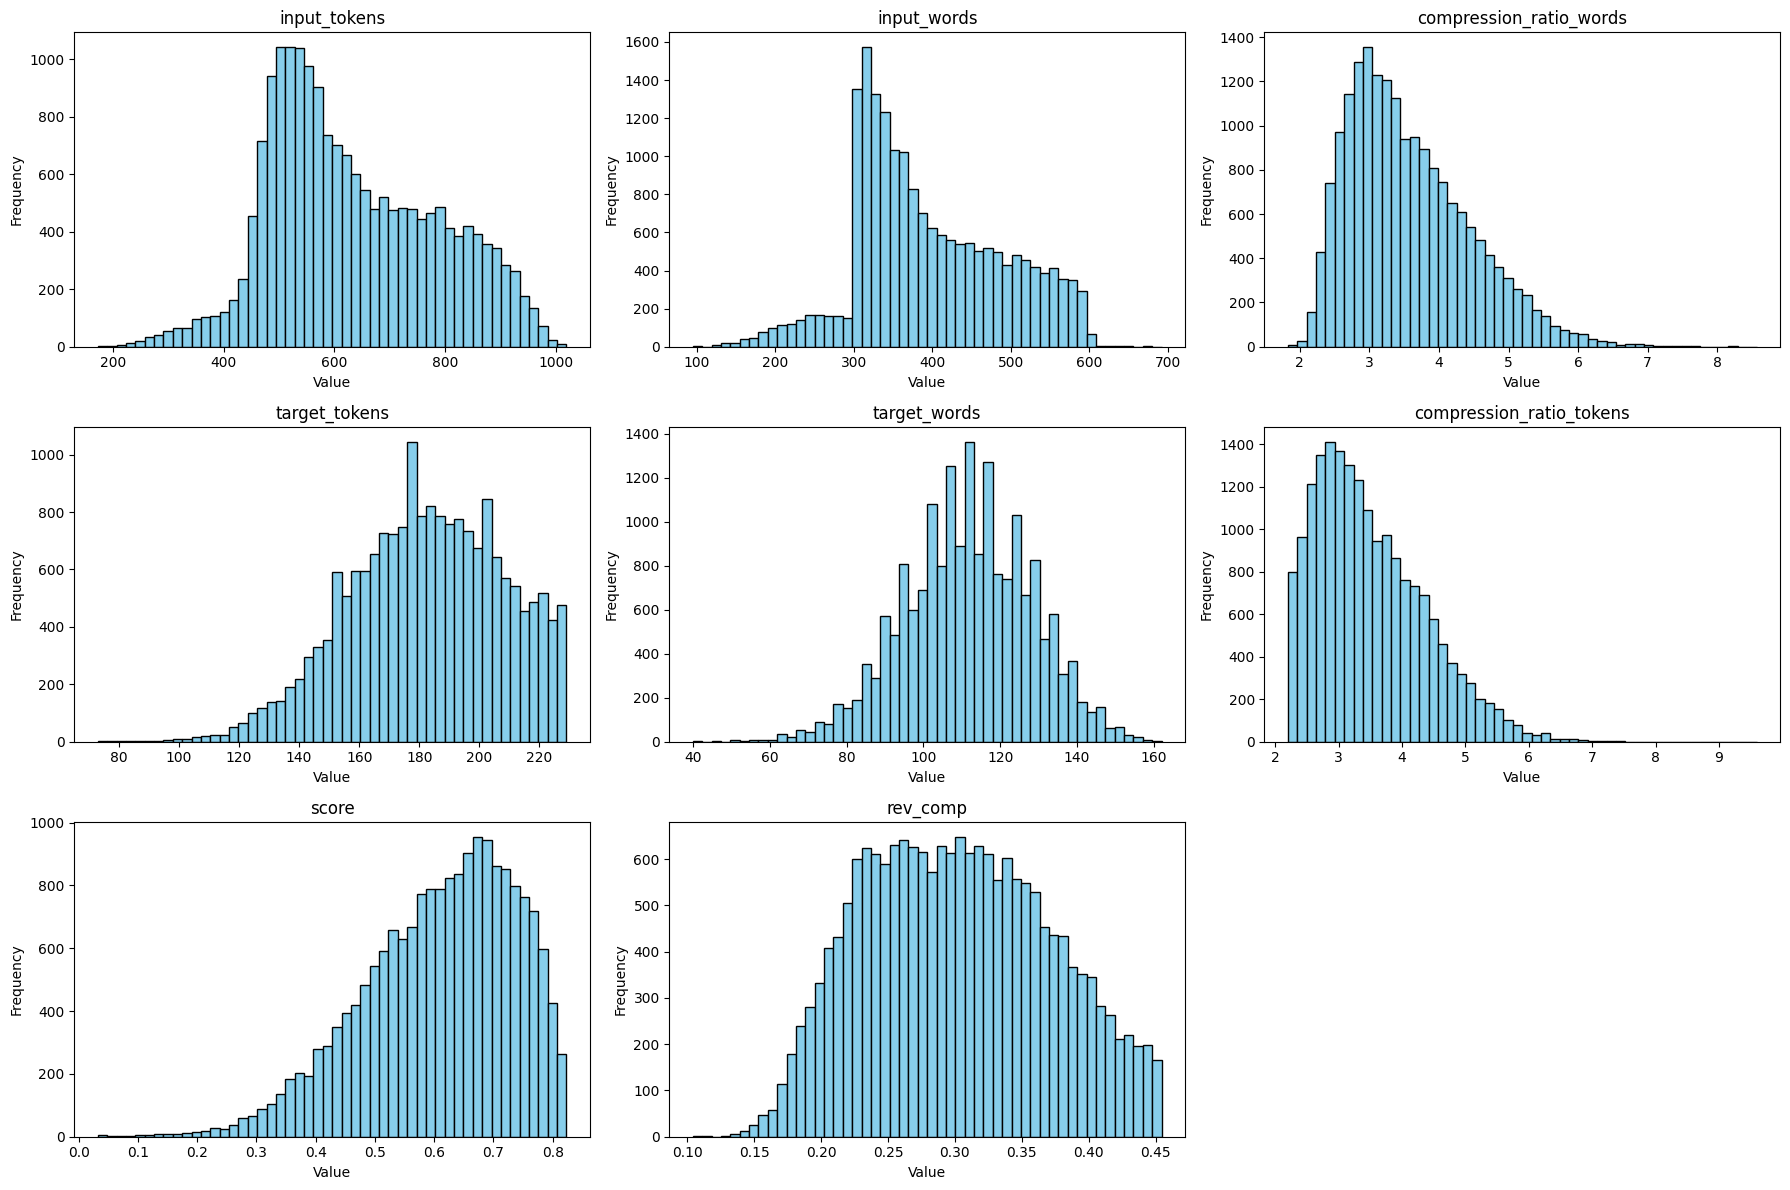

In [189]:
data_tools.plot_histograms(fultered_train, add_fields=["score", "rev_comp"])

<Axes: >

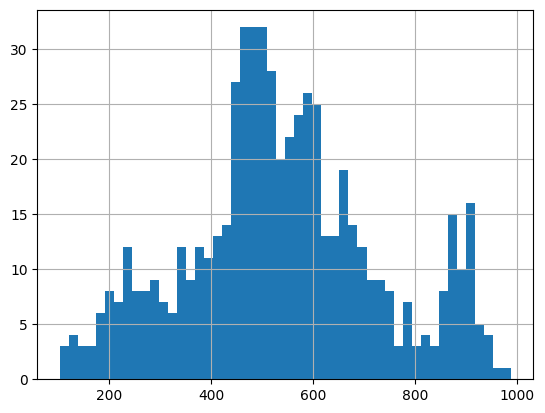

In [200]:
full_test['input_tokens'].hist(bins=50)

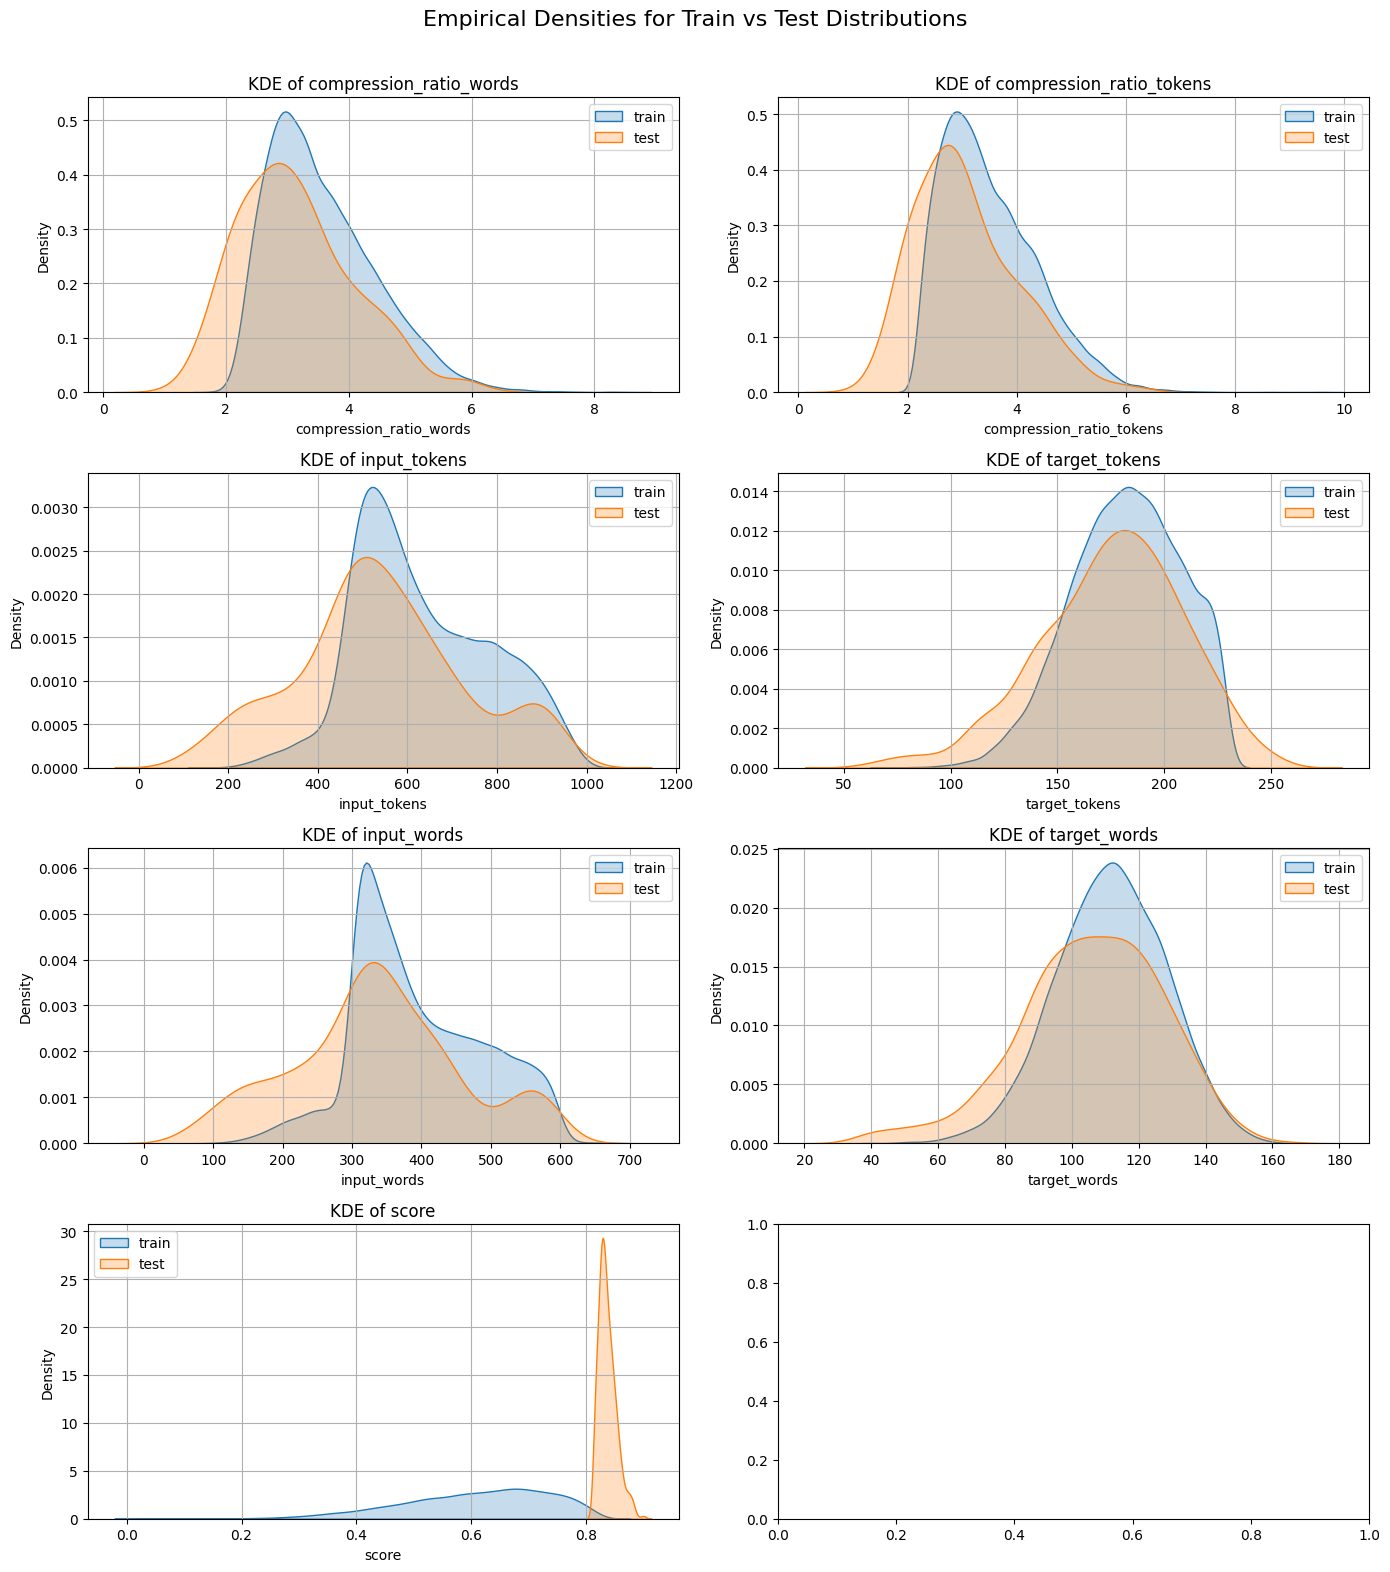

In [195]:
data_tools.cmp_train_test(fultered_train, full_test)

In [ ]:
combined_data = pd.concat([fultered_train, df1], ignore_index=True)

19203


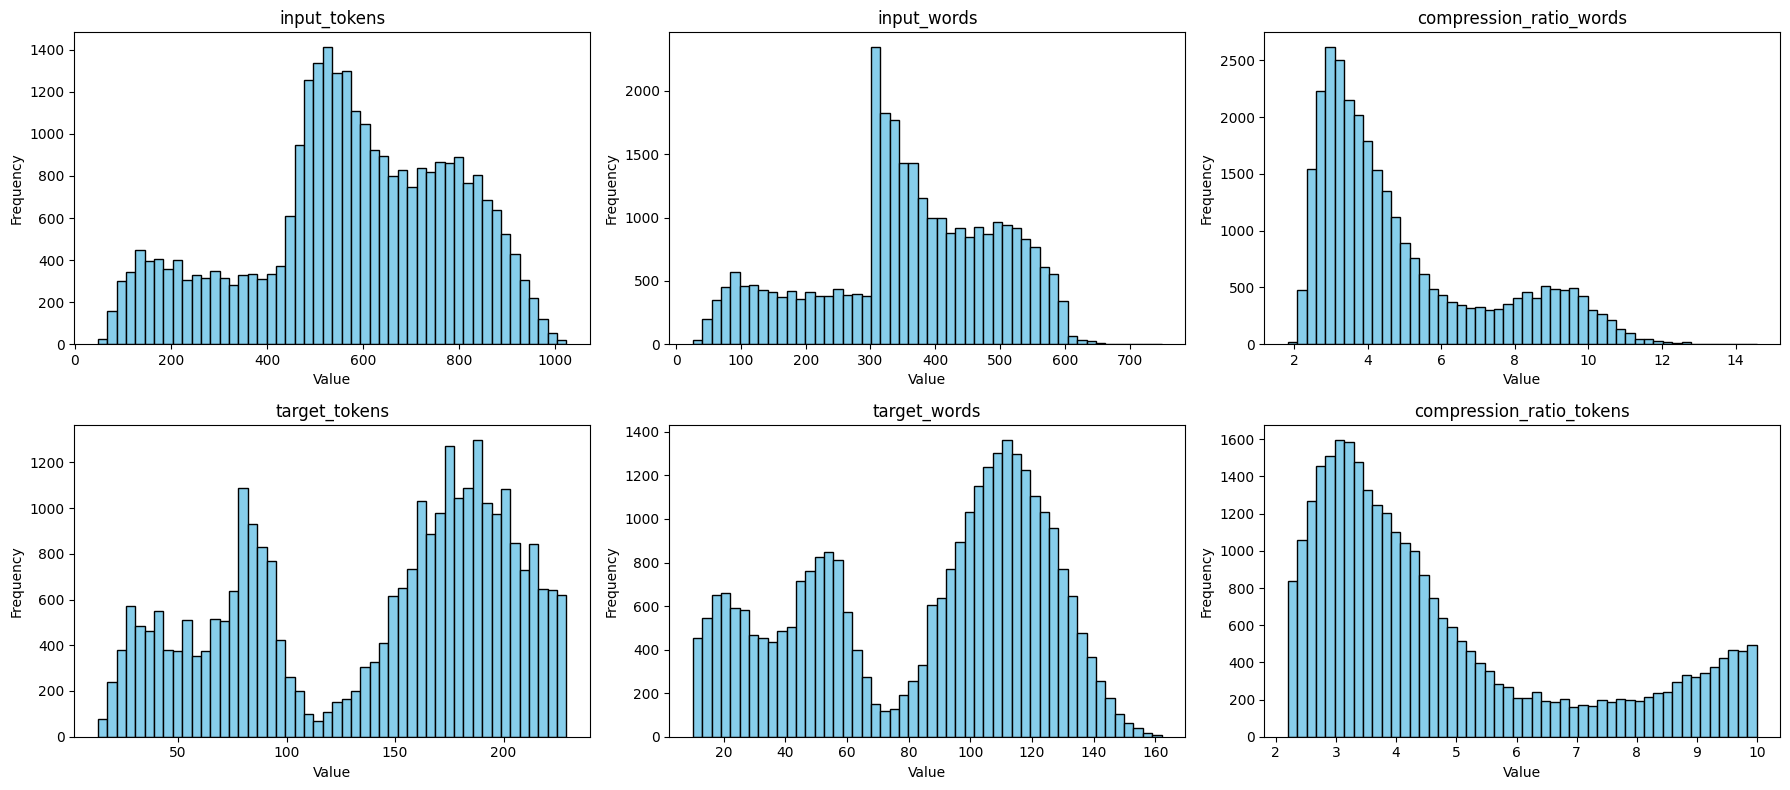

In [203]:
data_tools.plot_histograms(combined_data)

In [204]:
Dataset.from_pandas(combined_data[['text', 'summary']]).save_to_disk("../data/combined_train")

Saving the dataset (0/1 shards):   0%|          | 0/29746 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

old = load_from_disk('../data/combined_train_old')

In [154]:
old = old.map(data_tools.count, num_proc=8)

Map (num_proc=8):   0%|          | 0/32942 [00:00<?, ? examples/s]

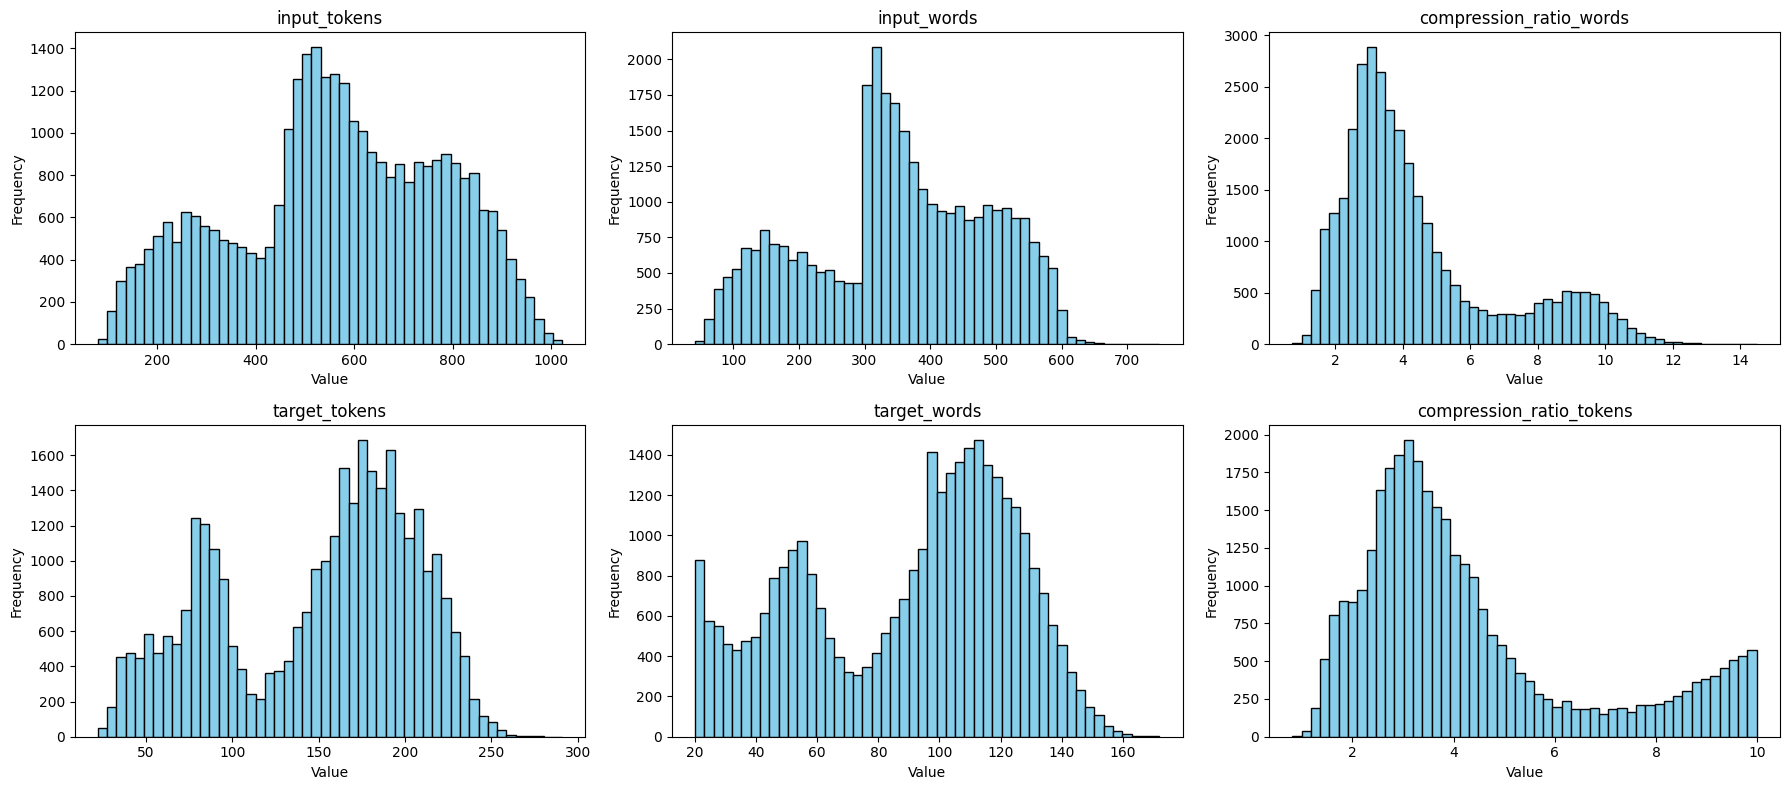

In [159]:
data_tools.plot_histograms(old.to_pandas())

# SEAHORSE

In [ ]:
from datasets import load_dataset, concatenate_datasets
seahorse = load_dataset("hgissbkh/seahorse")

In [ ]:
seahorse

In [ ]:
QUESTION = "conciseness"
LANGUAGES = ["ru", "en"]


def filter_data(example):
    if(example[QUESTION] == 0.5):
        return False

    example[QUESTION] = int(example[QUESTION])
    return example['lang'] in LANGUAGES #and len(example['summary']) > 15

seahorse_f = seahorse.filter(filter_data)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
# full = full.map(lambda x: {"len": len(tokenizer(x["summary"])["input_ids"])})

# import pandas as pd 

# df = pd.DataFrame(full)

# print(df["len"].describe())

# df["len"].hist(bins=20)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruT5-base")
FORMAT = "тест:\n {} саммари:\n {}"

def preprocess(examples):
    inputs = [FORMAT.format(article, summary)
              for article, summary in zip(examples['text'], examples['summary'])]
    tokenized = tokenizer(inputs, truncation=False)["input_ids"]
    return {"input_ids": tokenized}


seahorse_f = seahorse_f.map(preprocess, batched=True, num_proc=16)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
import pandas as pd

df = pd.DataFrame(full)

In [ ]:
df['sum_len'] = df['summary'].apply(len)

In [ ]:
df['sum_len'].describe()

In [ ]:
from nltk.tokenize import word_tokenize
df['sum_words'] = df['summary'].apply(lambda x: len([token for token in word_tokenize(x) if token.isalpha()]))

In [ ]:
df['sum_words'].describe()

In [ ]:
df[df.duplicated(["text", "summary"], keep=False)].sort_values("summary")

In [ ]:
print(df[QUESTION].value_counts())
df[QUESTION].value_counts().plot(kind='bar')